# 1. Data PreProcessing

In [176]:
# import modules
import pandas as pd
from torch import nn, torch, optim
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [6]:
# load data
df = pd.read_csv('data_scaled_mm.csv')
df = df.drop('Unnamed: 0', axis=1)

In [31]:
# X train-test split: 2021-01-01기준, index: 1096
data_train_x = df[:1096]
data_test_x = df[1096:]

In [32]:
# Y train-test split: 2021-01-01 기준, index: 1096
train_data = pd.read_csv('train.csv')
data_train_y = train_data[:1096]
data_test_y = train_data[1096:]

In [63]:
#sample: GW
data_train_GW_x = data_train_x.iloc[:,:7]
data_test_GW_x = data_test_x.iloc[:,:7]

data_train_GW_y = pd.DataFrame(data_train_y.iloc[:,1])
data_test_GW_y = pd.DataFrame(data_test_y.iloc[:,1])

In [181]:
# sample: GW, train/test data
data_train = pd.concat([data_train_GW_x, data_train_GW_y], axis = 1)
data_test = pd.concat([data_test_GW_x, data_test_GW_y], axis = 1)

In [182]:
# data scaling
# 1: minmax
# 2: standard error
# 3. normalizer
scaler_x = MinMaxScaler()
scaler_x.fit(data_train.iloc[:, :-1])
data_train.iloc[:,:-1] = scaler_x.transform(data_train.iloc[:, :-1])
data_test.iloc[:,:-1] = scaler_x.transform(data_test.iloc[:, :-1])

scaler_y = MinMaxScaler()
scaler_y.fit(data_train.iloc[:,[-1]])
data_train.iloc[:,-1] = scaler_y.transform(data_train.iloc[:, [-1]])
data_test.iloc[:,-1] = scaler_y.transform(data_test.iloc[:, [-1]])

In [183]:
data_test

,air_GW,real_pop_GW,pop_GW,pop_male_GW,pop_female_GW,mvpop_GW,station_GW,광진구
1096,0.117318,0.291149,-0.05539,1.021324,-0.048609,-0.038854,1.000000,0.161190
1097,0.139665,0.305331,-0.05539,1.021324,-0.048609,0.079625,1.000000,0.160567
1098,0.173184,0.386763,-0.05539,1.021324,-0.048609,0.021393,1.000000,0.149354
1099,0.167598,0.276711,-0.05539,1.021324,-0.048609,0.340721,1.000000,0.252141
1100,0.106145,0.279705,-0.05539,1.021324,-0.048609,0.349368,1.000000,0.223018
...,...,...,...,...,...,...,...,...
1456,0.106145,0.226884,-0.60218,1.083068,-0.456870,0.451440,1.195122,0.298240
1457,0.212291,0.221541,-0.60218,1.083068,-0.456870,0.484266,1.195122,0.351191
1458,0.279330,0.219172,-0.60218,1.083068,-0.456870,0.509474,1.195122,0.349634
1459,0.122905,0.248244,-0.60218,1.083068,-0.456870,0.547974,1.195122,0.346052


In [184]:
# lstm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np

In [185]:
# set parameters
seq_length = 100 #wanna predict one from 365 data points
batch = 14 #arbitrary

In [186]:
# dataset generator
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length,[-1]]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [187]:
# train-test datset as tensors
trainX, trainY = build_dataset(np.array(data_train), seq_length)
testX, testY = build_dataset(np.array(data_test), seq_length)

trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [188]:
#data_train
#data_test
trainX[0][0]

array([0.2122905 , 0.71759796, 1.        , 0.        , 1.        ,
       0.29779326, 0.        , 0.04609874])

In [189]:
# define dataset in tensor format
dataset = TensorDataset(trainX_tensor, trainY_tensor)
dataloader = DataLoader(dataset, batch_size = batch, shuffle = True, drop_last = True)

# 2. LSTM data pipeline

[customizing parameters]
1. data_dim: the number of features
2. hidden_dim: hidden_state
3. output_dim: the number of output values
4. learning_rate: learning rate, 0.01 in general
5. nb_epochs


[customnizing optimizer]
adam, adgrad, etc.

In [203]:
device = torch.device('cpu')
# customized parameters
data_dim = 8
hidden_dim = 5
output_dim = 1
learning_rate = 0.01
nb_epochs = 500

In [210]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers) #dropout = 0.1, #batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

        # to initialize learning
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
            )
        # for prediction
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:,-1])
        return x


In [219]:
# model
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
    criterian = nn.L1Loss().to(device) #mae loss
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # for each epoch, save loss
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples

            # hidden state rest for each seq
            model.reset_hidden_state()

            # H(x)
            outputs = model(x_train)

            # cost
            loss = criterian(outputs, y_train)

            # improve H(x) by cost
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
        
        # early stop
        if (epoch % patience ==0) & (epoch != 0):

            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                break
            
    return model.eval(), train_hist

In [220]:
# train model
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.2195
Epoch: 0020 train loss : 0.1861
Epoch: 0040 train loss : 0.1591
Epoch: 0060 train loss : 0.1197
Epoch: 0080 train loss : 0.1032
Epoch: 0100 train loss : 0.0997
Epoch: 0120 train loss : 0.0983

 Early Stopping


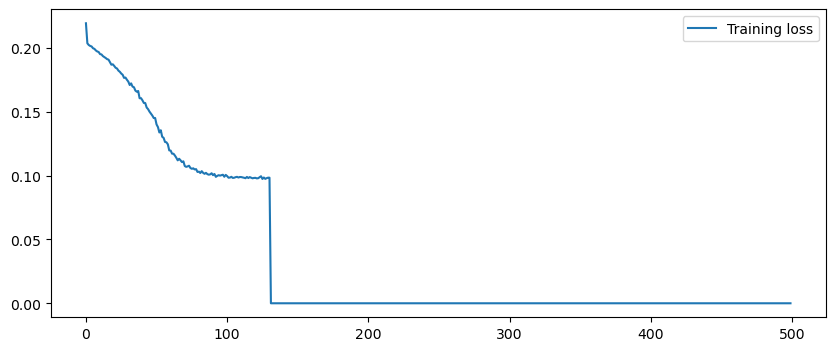

In [221]:
# loss by epoch
fig = plt.figure(figsize = (10,4))
plt.plot(train_hist, label = 'Training loss')
plt.legend()
plt.show()

In [222]:
# evaluation
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  1.992694083806774


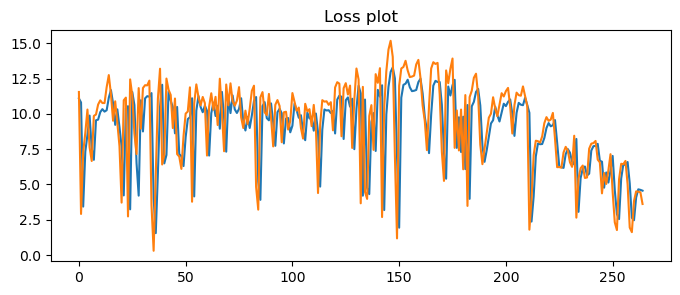

In [223]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.show()

# 3. Model Selection

In [224]:
# feature selection by using lasso regression
# import modules
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [242]:
# Lasso
#df
#print(train_data.iloc[:,1])
# print(df.iloc[:,:7])
X_train, X_test, y_train, y_test = train_test_split(np.array(df.iloc[:,:7]),np.array(train_data.iloc[:,1]),
test_size = 0.33, random_state = 42)


In [243]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

In [244]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [245]:
search.fit(X_train,y_train)
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-9.047 total time=   0.0s
[CV 2/5] END .................model__alpha=0.1;, score=-8.818 total time=   0.0s
[CV 3/5] END .................model__alpha=0.1;, score=-9.382 total time=   0.0s
[CV 4/5] END .................model__alpha=0.1;, score=-9.339 total time=   0.0s
[CV 5/5] END .................model__alpha=0.1;, score=-8.400 total time=   0.0s
[CV 1/5] END .................model__alpha=0.2;, score=-9.255 total time=   0.0s
[CV 2/5] END .................model__alpha=0.2;, score=-8.790 total time=   0.0s
[CV 3/5] END .................model__alpha=0.2;, score=-9.560 total time=   0.0s
[CV 4/5] END .................model__alpha=0.2;, score=-9.546 total time=   0.0s
[CV 5/5] END .................model__alpha=0.2;, score=-8.834 total time=   0.0s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-9.573 total time=   0.0s
[CV 2/5] END .model__alpha=0.30000000000000004;

In [246]:
coefficients # let's get rid of 2nd and 6th feature

array([-0.12452048, -0.05029428, -0.        ,  0.43342441, -1.66984504,
        0.85055425,  0.        ])